In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from imutils.object_detection import non_max_suppression
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [21]:
def selective_search(image, method="fast"):
    # initialize OpenCV's selective search implementation and set the input image
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    
    # check to see if we are using "fast" but "less accurate" version of selective search
    if method == "fast":
        ss.switchToSelectiveSearchFast()
        
    # otherwise we are using "slower" but "more accurate" version
    else:
        ss.switchToSelectiveSearchQuality()
        
    # run selective search on the input image
    rects = ss.process()
    
    # return the region proposal bounding boxes
    return rects

In [22]:
class DictX(dict):
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError as k:
            raise AttributeError(k)

    def __setattr__(self, key, value):
        self[key] = value

    def __delattr__(self, key):
        try:
            del self[key]
        except KeyError as k:
            raise AttributeError(k)

    def __repr__(self):
        return '<DictX ' + dict.__repr__(self) + '>'

In [23]:
args = DictX ({
    "image": "./beagle.png", # location of image
    "method": "fast",          # ["fast", "slow"]
    "conf": "0.9",             # minimum probabilty to consider a classification/detection
    "filter": "beagle"             # comma separated list of ImageNet labels to filter on
})

In [24]:
# grab label filters
labelFilters = args.filter

# if the label filter is not empty, break it into a list
if labelFilters is not None:
    labelFilters = labelFilters.lower().split(",")

In [25]:
# load ResNet (with weights pre-trained on ImageNet)
print ("Loading ResNet...")
model = ResNet50(weights="imagenet")

# load the input image from disk and grab its dimensions
image = cv2.imread(args.image)
(H, W) = image.shape[:2]

Loading ResNet...


In [26]:
print (type(image))

<class 'numpy.ndarray'>


In [27]:
print ("performing selective search with '{}' method".format(args.method))
rects = selective_search(image, method=args.method)
print ("{} regions found by selective search".format(len(rects)))

# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []

performing selective search with 'fast' method
922 regions found by selective search


In [28]:
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects:
    # if the width or height of the region is less than 10% of the
    # image width or height, ignore it (i.e., filter out small
    # objects that are likely false-positives)
    if w/float(W) < 0.1 or h/float(H) < 0.1:
        continue
        
    # extract the region from the input image, convert it from BGR to
    # RGB channel ordering, and them resize it to 224x224 (the input
    # dimesnsion required by our pretrained CNN)
    roi = image[y:y+h, x:x+w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, (224, 224))
    
    # further processing by the ROI
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    
    # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, w, h))

In [29]:
# convert the proposals list into numpy array and show its dimensions
proposals = np.array(proposals)
print ("Proposal shape: {}".format(proposals.shape))

# classify each of the proposal ROIs using ResNet and then decode the
# predictions
print ("Classifying proposals...")
preds = model.predict(proposals)
preds = imagenet_utils.decode_predictions(preds, top=1)

# initialize a dictionary which maps class labels (keys) to any
# bounding box associated with that label (values)
labels = {}

Proposal shape: (534, 224, 224, 3)
Classifying proposals...


In [30]:
# loop over the predictions
for (i, p) in enumerate(preds):
    # grab the prediction information for the current region proposal
    (imagenetID, label, prob) = p[0]
    
    # only if the label filters are not empty "and" the label does not
    # exist in the list, then ignore it
    if labelFilters is not None and label not in labelFilters:
        continue
    
    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if prob >= float(args.conf):
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        (x, y, w, h) = boxes[i]
        box = (x, y, x + w, y + h)
        
        # grab the list of predictions for the label and add the
        # bounding box + probability to the list
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

In [31]:
labels

{'beagle': [((203, 0, 431, 284), 0.9236124),
  ((268, 67, 430, 275), 0.91915184),
  ((241, 63, 392, 228), 0.90226185),
  ((173, 0, 431, 284), 0.97202075),
  ((289, 63, 386, 197), 0.95546585),
  ((219, 67, 324, 178), 0.9191459),
  ((289, 64, 381, 199), 0.92884403),
  ((159, 0, 431, 284), 0.98327845),
  ((268, 75, 403, 275), 0.9596374),
  ((0, 0, 500, 336), 0.93988574),
  ((205, 63, 431, 242), 0.9647249),
  ((0, 60, 324, 268), 0.96769744),
  ((289, 65, 381, 197), 0.9581511),
  ((38, 0, 431, 284), 0.96430355),
  ((0, 0, 431, 284), 0.9833123),
  ((289, 65, 381, 199), 0.91113424),
  ((81, 88, 279, 270), 0.94199175),
  ((0, 0, 355, 220), 0.9366166),
  ((205, 64, 381, 242), 0.9431784),
  ((81, 83, 279, 270), 0.91140974),
  ((0, 0, 437, 336), 0.9698598),
  ((199, 63, 430, 275), 0.94493186),
  ((268, 75, 392, 237), 0.9781186),
  ((79, 0, 354, 268), 0.9557671),
  ((199, 63, 431, 242), 0.9575195),
  ((246, 63, 381, 214), 0.94851065),
  ((0, 0, 319, 237), 0.94338024),
  ((37, 67, 324, 268), 0.9329

In [33]:
boxes = np.array([p[0] for p in labels["beagle"]])
proba = np.array([p[1] for p in labels["beagle"]])
boxes = non_max_suppression(boxes, proba)

In [34]:
boxes

array([[111,   0, 415, 289]])

In [37]:
clone = image.copy()

In [38]:
for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),
            (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

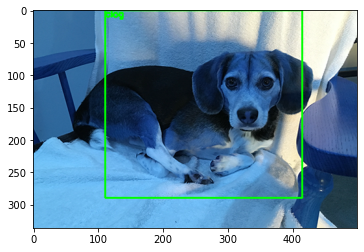

In [39]:
plt.imshow(clone)

[INFO] showing results for 'beagle'
[INFO] showing results for 'quill'
[INFO] showing results for 'clog'
[INFO] showing results for 'paper_towel'


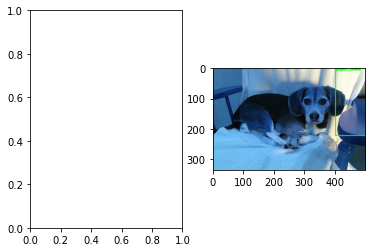

In [19]:
# f = plt.figure()
# f.add_subplot(1,2, 1)
# f.add_subplot(1,2, 2)
for label in labels.keys():
    # clone the original image so that we can draw on it
#     print("[INFO] showing results for '{}'".format(label))
#     clone = image.copy()
#     # loop over all bounding boxes for the current label
#     for (box, prob) in labels[label]:
#         # draw the bounding box on the image
#         (startX, startY, endX, endY) = box
#         cv2.rectangle(clone, (startX, startY), (endX, endY),
#             (0, 255, 0), 2)
#     # show the results *before* applying non-maxima suppression, then
#     # clone the image again so we can display the results *after*
#     # applying non-maxima suppression
#     # cv2.imshow("Before", clone)
#     # plt.imshow(clone)
#     clone = image.copy()
    
    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)
    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),
            (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    # show the output after apply non-maxima suppression
    # cv2.imshow("After", clone)
    # cv2.waitKey(0)
#     plt.imshow(clone)
# plt.show(block=True)

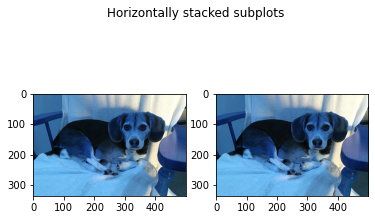

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
for i in range(2):
    
ax1.imshow(image)
ax2.imshow(image)
plt.show()

In [17]:
# from PIL import Image

# img = Image.fromarray(clone2, 'RGB')
# img.save('my.png')
# img.show()

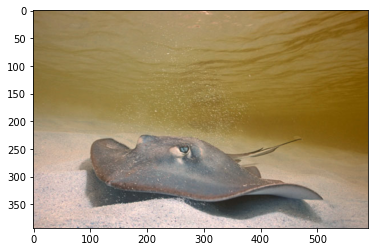

In [21]:
import matplotlib.pyplot as plt

plt.imshow(clone1, aspect="auto")
plt.show()

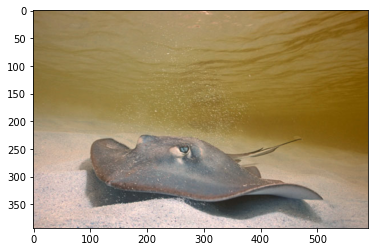

In [22]:
plt.imshow(clone2, aspect="auto")
plt.show()

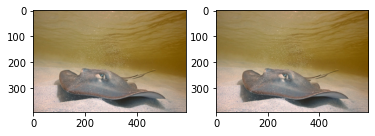

In [26]:
# f, axarr = plt.subplots(1)
# axarr[0].imshow(clone1)
# axarr[1].imshow(clone2)
# plt.show()


f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(clone1)
f.add_subplot(1,2, 2)
plt.imshow(clone2)
plt.show(block=True)